In [1]:
# python -m notebook --ip=0.0.0.0 --no-browser \
#                    --NotebookApp.allow_origin='*' \
#                    --NotebookApp.token='' \
#                    --NotebookApp.password=''
# ssh mac9908@sporcsubmit.rc.rit.edu -L 8888:clx-a-01.rc.rit.edu:8888
# spack load py-pip/ylgeevx
import datasets
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
palette = {'CLARA':"#9b59b6", 'FA(L)':"#3498db", 'FA(L+E)':"#95a5a6"}
class ClaraAnalysis():
    def __init__(self) -> None:
        self.dataset_dir = 'dataset'
        self.techniques = {0: 'CLARA', 1: 'FA(L)', 3: 'FA(L+E)'}
        self.dataset = datasets.load_from_disk(self.dataset_dir)
        self.dataset = self.dataset.map(self.assign_technique)
        self.dataset = self.dataset.map(self.parse_error_output)
        self.dataframe = self.dataset['final'].to_pandas()
        self.difficulty = {
            '1A': 1000,
            '4A': 800,
            '4C': 1300,
            '50A': 800,
            '208A': 900,
            '214A': 800,
            '255A': 800,
            '265A': 800,
            '492B': 1200,
            '510A': 800,
            '1097A':800, 
            '1360B':800, 
            '1363A':1200, 
            '1364A':1200, 
            '1369B':1200, 
            '1370A':800, 
            '1382B':1100, 
            '1385A':800, 
            '1391A':800, 
            '1391B':800
        }
        # Setting proper types of data  
        self.dataframe['Technique'] = pd.Categorical(self.dataframe['Technique'])
        self.dataframe['Percentage Repaired'] = self.dataframe['Percentage Repaired'].astype(float)
        print("Test Available")
        display(self.dataframe.groupby(['Technique', 'Test Available'])['Technique'].count())
        self.dataframe = self.dataframe[self.dataframe['Test Available'].isna()!=True]
        print("List of Parse Errors:")
        display(self.dataframe[self.dataframe['Technique']=='CLARA'].groupby(['Parse Error Output'])['Technique'].count())
        self.dataframe = self.dataframe[self.dataframe['Parse Error'] != 'True']
        self.dataframe = self.dataframe[self.dataframe['Test Available'] == 'Yes']
        timeout = self.dataframe[self.dataframe['Timeout']==True]
        display("List of Timeouts")
        display(timeout.groupby(['Technique'])['Technique'].count())
        self.dataframe = self.dataframe[self.dataframe['Timeout'] !=True]
        self.dataframe['ci'] = self.dataframe['Correct File'] + '_' + self.dataframe['Incorrect File']
        grouped = self.dataframe.groupby('ci')
        self.dataframe = grouped.filter(lambda x: x['Technique'].count() == 3)
        self.dataframe['Difficulty'] = self.dataframe['Problem'].map(self.difficulty)

    def parse_error_output(self, x):
        if x['Parse Error'] == 'True':
            return {'Parse Error Output': re.findall(r':([^\(]+)', x['Error Output'].split('\n')[-2])[0]}
        else:
            return {'Parse Error Output': None}

    def assign_technique(self, x):
        x['Technique'] = self.techniques[x['Technique']]
        return x
    def group_analyze(self, column, type=None, filter=None):
        if type is not None:
          self.dataframe[column] = self.dataframe[column].astype(type)
        return self.dataframe.groupby([column])[column].count()

    def summary_statistic(self):
        pass

    def groups_analyze(self, columns, df=None):
        if df is None:
            df = self.dataframe
        return df.groupby(columns)[columns].count()

    def filter_group_analyze(self, column, type=None):
        dt_parse_error = self.dataset.filter(lambda x: x['Parse Error'] == 'True')\
          .map(self.parse_error_output)
        print(self.group_analyze(dt_parse_error['final'].to_pandas(), 'Parse Error Output', type="category"))

    def draw_boxplot(self, groups, title='Title', ylabel='YLabel'):
        data = [self.dataframe[grp].astype(float).to_numpy() for grp in groups]
        sns.boxplot(data)
clara = ClaraAnalysis()

Loading cached processed dataset at /home/mac9908/clara/problems/dataset/final/cache-62645333ce2a439e.arrow
Loading cached processed dataset at /home/mac9908/clara/problems/dataset/final/cache-4ad53523e2f6e65d.arrow


Test Available


Technique  Test Available
CLARA      No                25396
           Yes               66327
FA(L)      No                25396
           Yes               58961
FA(L+E)    No                25396
           Yes               57070
Name: Technique, dtype: int64

List of Parse Errors:


Parse Error Output
 'Import' object has no attribute 'name'                                           534
 'Subscript' object has no attribute 'id'                                           32
 Assignments to Attribute not supported                                           4244
 Assignments to List not supported                                                 351
 Call of Call not supported                                                         11
 Call of Subscript not supported                                                     5
 Call to Attribute                                                                 237
 Comprehension: not a list of names                                                  6
 Delete target: <class 'clara.model.Var'>                                           11
 For loop with List as target                                                        7
 For-Else not supported                                                           1979
 Multiple delete targets

'List of Timeouts'

Technique
CLARA       28
FA(L)      291
FA(L+E)    438
Name: Technique, dtype: int64

In [95]:
class ClaraHelperMethods:
    def __init__(self):
        self.figsize = (10,7)
        self.axes = [0,0,1,1]
        self.font_scale = 1
        self.style = "white"
        self.palette = {'CLARA':"#9b59b6", 'FA(L)':"#3498db", 'FA(L+E)':"#95a5a6"}
        self.other_palette = ["#9b59b6","#3498db","#95a5a6"]
        self.order = [
            "4A",
            "50A",
            "214A",
            "255A",
            "265A",
            "510A",
            "1097A",
            "1360B",
            "1370A",
            "1385A",
            "1391A",
            "1391B",
            "208A",
            "1A",
            "1382B",
            "492B",
            "1363A",
            "1364A",
            "1369B",
            "4C"
        ]
        self.fontsize = 36
        self.legend = 'upper right'
    def add_bin_col(self, x, df, col='locs_bin'):
        row = df.loc[(df[col].isna() != True)]
        row = row[row['Correct File'] == x['Correct File']]
        if len(row[col]) > 0:
            x[col] = row[col].iloc[0]
        return x
    
    def do_bin(self, df, new_col='locs_bin', bin_column='Correct Locs', bins=[0,10,20,30,40,50,60,70,80]):
        df[new_col] = pd.cut(np.array(df[bin_column]), bins=bins)
        # df[df[new_col].isna() != True]['Correct File']
        df = df.apply(lambda x: self.add_bin_col(x, df, col=new_col), axis=1)
        return df
    def successful_repair_percentage(self, df, col=['Technique']):
        succesful_repairs = df[df['Repairs'].isna()!=True].groupby(col)['Problem'].count()
        total_repairs = df.groupby(col)['Problem'].count()
        repaired = succesful_repairs/total_repairs
        return repaired
    
       
          
    def plot_success(self, df, figname, xlabel, ylabel="",
                     y_labels=None, x_labels=None, legend=None,
                     repair=None, col=['Technique'],
                     figsize=None, axes=None, font_scale=None,
                     style=None, fontsize=None):
        figsize = figsize if figsize else self.figsize
        axes = axes if axes else self.axes
        font_scale = font_scale if font_scale else self.font_scale
        style = style if style else self.style
        fontsize = fontsize if fontsize else self.fontsize
        if not repair:
            repair = self.successful_repair_percentage(df, col=col)
            display(repair)
        fig = plt.figure(figsize = figsize)
        ax = fig.add_axes(axes)
        sns.set(font_scale=font_scale)
        sns.set_style(style)
        x = repair.index.get_level_values(col[0]) if len(col)>1 else repair.index
        y = repair.values*100
        hue = repair.index.get_level_values(col[1]) if len(col)>1 else None
        sns.barplot(x=x,
                    hue=hue, 
                    y=y, 
                    ax=ax, 
                    palette=self.palette)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)
        if legend:
            ax.legend(loc=legend, bbox_to_anchor=(1.3, 1), borderaxespad=0, fontsize=24)
        else:
            ax.legend([],[],frameon=False)
        if x_labels:
            ax.set_xticklabels(x_labels, size = fontsize)
        else:
            ax.set_xticklabels(ax.get_xticklabels(), size = fontsize)
        if y_labels:
            ax.set_yticklabels(y_labels, size = fontsize)
        else:
            ax.set_yticklabels(ax.get_yticklabels(), size = fontsize)
        plt.savefig(figname, format="pdf", bbox_inches='tight')
        
    def plot_box(self, df, figname, xlabel, ylabel="",
                 orient="v",col=['Correct Locs', 'Technique'],
                 x_labels=None, y_labels=None,order=None,
                 figsize=None, hue=None, whis=1.5, legend=None,
                 axes=None, font_scale=None,style=None, fontsize=None, 
                 hue_order=None):
        figsize = figsize if figsize else self.figsize
        axes = axes if axes else self.axes
        font_scale = font_scale if font_scale else self.font_scale
        style = style if style else self.style
        fontsize = fontsize if fontsize else self.fontsize
        fig = plt.figure(figsize = self.figsize)
        palette = self.palette
        if not hue:
            palette = self.other_palette
        if not hue_order:
            hue_order = self.palette.keys()
        ax = fig.add_axes(self.axes)
        if not order:
            order = df.groupby(col[1])[col[1]].count().index
        ax = sns.boxplot(
            data=df, 
            y=col[0],
            x=col[1],
            hue=hue,
            orient=orient,
            whis=whis,
            order=order,
            hue_order=hue_order,
            palette=palette)
        
        if legend:
            ax.legend(loc=legend, bbox_to_anchor=(1.3, 1), borderaxespad=0, fontsize=24)
        else:
            ax.legend([],[],frameon=False)
        if x_labels:
            ax.set_xticklabels(x_labels, size = fontsize)
        else:
            ax.set_xticklabels(ax.get_xticklabels(), size = fontsize)
        if y_labels:
            ax.set_yticklabels(y_labels, size = fontsize)
        else:
            ax.set_yticklabels(ax.get_yticklabels(), size = fontsize)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)
        plt.savefig(figname, format="pdf", bbox_inches='tight')
    
    def plot_bar(self, df, figname, xlabel, ylabel="",
                 orient="v",col=['Correct Locs', 'Technique'],
                 x_labels=None, y_labels=None,order=None,
                 figsize=None, hue=None, whis=1.5, legend=None,
                 axes=None, font_scale=None,style=None, fontsize=None):
        figsize = figsize if figsize else self.figsize
        axes = axes if axes else self.axes
        font_scale = font_scale if font_scale else self.font_scale
        style = style if style else self.style
        fontsize = fontsize if fontsize else self.fontsize
        fig = plt.figure(figsize = self.figsize)
        palette = self.palette
        if not hue:
            palette = self.other_palette
        ax = fig.add_axes(self.axes)
        if not order:
            order = df.groupby(col[1])[col[1]].count().index
#         ax = sns.boxplot(
#             data=df, 
#             y=col[0],
#             x=col[1],
#             hue=hue,
#             orient=orient,
#             whis=whis,
#             order=order,
#             palette=palette)
        ax = sns.barplot(
            data=df,
            hue=hue, 
            y=col[0],
            x=col[1],
            order=order,
            ax=ax, 
            palette=self.palette)
        if legend:
            ax.legend(loc=legend, bbox_to_anchor=(1.3, 1), borderaxespad=0, fontsize=24)
        else:
            ax.legend([],[],frameon=False)
        if x_labels:
            ax.set_xticklabels(x_labels, size = fontsize)
        if y_labels:
            ax.set_yticklabels(y_labels, size = fontsize)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)
        plt.savefig(figname, format="pdf", bbox_inches='tight')
util = ClaraHelperMethods()

In [3]:
unfiltered_df = clara.dataset['final'].to_pandas()

## Table 5: Program comparisons available in our dataset and summary of invalidity reasons

In [4]:
'''
        self.dataset = datasets.load_from_disk(self.dataset_dir)
        self.dataset = self.dataset.map(self.assign_technique)
        self.dataset = self.dataset.map(self.parse_error_output)
        self.dataframe = self.dataset['final'].to_pandas()
        self.dataframe['Technique'] = pd.Categorical(self.dataframe['Technique'])
        self.dataframe['Percentage Repaired'] = self.dataframe['Percentage Repaired'].astype(float)
        print("Test Available")
        display(self.dataframe.groupby(['Technique', 'Test Available'])['Technique'].count())
        self.dataframe = self.dataframe[self.dataframe['Test Available'].isna()!=True]
        print("List of Parse Errors:")
        display(self.dataframe[self.dataframe['Technique']=='CLARA'].groupby(['Parse Error Output'])['Technique'].count())
        self.dataframe = self.dataframe[self.dataframe['Parse Error'] != 'True']
        self.dataframe = self.dataframe[self.dataframe['Test Available'] == 'Yes']
        timeout = self.dataframe[self.dataframe['Timeout']==True]
        display("List of Timeouts")
        display(timeout.groupby(['Technique'])['Technique'].count())
        self.dataframe = self.dataframe[self.dataframe['Timeout'] !=True]
        self.dataframe['ci'] = self.dataframe['Correct File'] + '_' + self.dataframe['Incorrect File']
        grouped = self.dataframe.groupby('ci')
        self.dataframe = grouped.filter(lambda x: x['Technique'].count() == 3)
        self.dataframe['Difficulty'] = self.dataframe['Problem'].map(self.difficulty)
'''
def assign_bins_and_remove_no_correct(df, col):
    cfiles = df.groupby(['Correct File'])[col].max()
    mapping = {}
    for idx, c in enumerate(cfiles.index):
        mapping[c] = cfiles.values[idx]
    df[col] = df['Correct File'].map(mapping)
    return df
def do_maps(df, clara):
    df['Difficulty'] = df['Problem'].map(clara.difficulty)
    df[['prob_num', 'prob_letter']] = df['Problem'].str.extract(r'([0-9]+)([A-Z])')
    df['prob_num'] = df['prob_num'].astype(int)
    df['locs_bin'] = pd.cut(np.array(df['Correct Locs']), bins=[0,4,5,15,40,80])
    df['exprs_bin'] = pd.cut(np.array(df['Correct Exprs']), bins=[0,4,10,20,40,80])
    df = assign_bins_and_remove_no_correct(df, 'locs_bin')
    df = assign_bins_and_remove_no_correct(df, 'exprs_bin')
    return df
def ensure_equivalence(df):
    df['ci'] = df['Correct File'] + '_' + df['Incorrect File']
    grouped = df.groupby('ci')
    df = grouped.filter(lambda x: x['Technique'].count() == 3)
    return df
class Calculate:
    def unavailable_test_cases(df, experiment):
        df = df[df['Technique']==experiment]
        len1 = len(df[df['Test Available'].isna()==True])
        len2 = len(df[df['Test Available']=='No'])
        return 'Unavailable Test Cases', len1+len2
    def unsupported_language_constructs(df, experiment):
        df = df[df['Technique']==experiment]
        df = df[df['Parse Error']=='True']
        len1 = len(df[df['Parse Error Output'].str.contains('Unimplemented')])
        len2 = len(df[df['Parse Error Output'].str.contains('For-Else')])
        len3 = len(df[df['Parse Error Output'].str.contains('While-Else')])
        return 'Unsupported Language Constructs', len1+len2+len3
    def keyword_arguments(df, experiment):
        df = df[df['Technique']==experiment]
        df = df[df['Parse Error']=='True']
        len1 = len(df[df['Parse Error Output'].str.contains('keyword')])
        return 'Keyword Arguments', len1
    def unsupported_class_attributes(df, experiment):
        df = df[df['Technique']==experiment]
        df = df[df['Parse Error']=='True']
        total_len = len(df)
        len1 = len(df[df['Parse Error Output'].str.contains('Unimplemented')])
        len2 = len(df[df['Parse Error Output'].str.contains('For-Else')])
        len3 = len(df[df['Parse Error Output'].str.contains('While-Else')])
        len4 = len(df[df['Parse Error Output'].str.contains('keyword')])
        len5 = total_len - (len1+len2+len3+len4)
        return 'Unsupported Class Attributes', len5
    def timeout(df, experiment):
        df = df[df['Technique']==experiment]
        len1 = len(df[df['Timeout'] == True])
        len2 = len(df[df['Timeout'].isna() == True])
        return 'Timeout', len1+len2
#     def runtime_errors(df, experiment):
#         df = df[df['Technique']==experiment]
#         df = df[df['Test Available'].isna()!=True]
#         df = df[df['Test Available']!='No']
#         df = df[df['Parse Error']!='True']
#         df = df[df['Timeout']!=True]
#         df = ensure_equivalence(df)
#         len1 = len(df[df['locs_bin'].isna()==True])
#         tmp = df[df['locs_bin'].isna()!=True]
#         len2 = len(tmp[tmp['exprs_bin'].isna()==True])
#         return 'Runtime Errors', len1+len2

def filter_out_all_invalid(df, clara):
#     df = df[df['locs_bin'].isna()!=True]
#     df = df[df['exprs_bin'].isna()!=True]
    df = df[df['Test Available'].isna()!=True]
    df = df[df['Test Available']!='No']
    df = df[df['Parse Error']!='True']
    df = df[df['Parse Error']!='True']
    df = df[df['Timeout']!=True]
    df = ensure_equivalence(df)
    return df

        
def table5(df, clara):
    df = ensure_equivalence(df)
    dic = {}
    for exp in clara.techniques.values():
        print(exp)
        dic[f'{exp}'] = []
        dic[f'{exp}_count'] = []
        total_len = len(df[df['Technique']==exp])
        total_invalid = 0
        for fn in dir(Calculate):
            if '__' not in fn:
                fnc = getattr(Calculate, fn)
                t,c = fnc(df, exp)
                total_invalid+= c
                dic[f'{exp}'].append(t)
                dic[f'{exp}_count'].append(c)
        dic[f'{exp}'].append('Total Invalid')
        dic[f'{exp}_count'].append(total_invalid)
        dic[f'{exp}'].append('Total Valid')
        dic[f'{exp}_count'].append(total_len-total_invalid)
        dic[f'{exp}'].append('Total Comparisons')
        dic[f'{exp}_count'].append(total_len)
    
    table = pd.DataFrame.from_dict(dic)
    df = filter_out_all_invalid(df, clara)
    table.loc[8] = ['Total Common Valid', len(df)//3, 'Total Common Valid', len(df)//3, 'Total Common Valid', len(df)//3]
    return table, df
filtered_df = do_maps(unfiltered_df, clara)
table_5, df_after_table5 = table5(filtered_df, clara)
display(table_5)

CLARA
FA(L)
FA(L+E)


,CLARA,CLARA_count,FA(L),FA(L)_count,FA(L+E),FA(L+E)_count
0,Keyword Arguments,5148,Keyword Arguments,5148,Keyword Arguments,5148
1,Timeout,9,Timeout,191,Timeout,172
2,Unavailable Test Cases,25485,Unavailable Test Cases,25498,Unavailable Test Cases,25498
3,Unsupported Class Attributes,7868,Unsupported Class Attributes,7868,Unsupported Class Attributes,7868
4,Unsupported Language Constructs,26152,Unsupported Language Constructs,26152,Unsupported Language Constructs,26152
5,Total Invalid,64662,Total Invalid,64857,Total Invalid,64838
6,Total Valid,15925,Total Valid,15730,Total Valid,15749
7,Total Comparisons,80587,Total Comparisons,80587,Total Comparisons,80587
8,Total Common Valid,15688,Total Common Valid,15688,Total Common Valid,15688


## Table 6  Dataset statistics for valid programs, where LOC and Exprs. respectively indicate total lines of code and number of expressions, and Diff. is the problem’s difficulty

In [39]:
def assign_bins_and_remove_no_correct(df, col):
    cfiles = df.groupby(['Correct File'])[col].max()
    mapping = {}
    for idx, c in enumerate(cfiles.index):
        mapping[c] = cfiles.values[idx]
    df[col] = df['Correct File'].map(mapping)
    return df
def table6(df, clara):
    table = pd.DataFrame({
        'difficulty': df.groupby(['Problem'])['Difficulty'].mean(),
        'total_unique': df.groupby(['Problem'])['ci'].nunique(),
        'total': df.groupby(['Problem'])['ci'].count(),
        'correct': df.groupby(['Problem'])['Correct File'].nunique(),
        'incorrect': df.groupby(['Problem'])['Incorrect File'].nunique(),
        'loc' : df.groupby(['Problem'])['Correct Locs'].mean().round(2).astype(str)+" +- "+df.groupby(['Problem'])['Correct Locs'].std().round(2).astype(str),
        'exprs': df.groupby(['Problem'])['Correct Exprs'].mean().round(2).astype(str)+" +- "+df.groupby(['Problem'])['Correct Exprs'].std().round(2).astype(str),
        'prob_num': df.groupby(['Problem'])['prob_num'].max(),
        'prob_letter': df.groupby(['Problem'])['prob_letter'].max(),
    })
    table.loc['Total'] = ['', table['total_unique'].sum(),table['total'].sum(),table['correct'].sum(),table['incorrect'].sum(),'','','','']
    return table.sort_values(by=['difficulty','prob_num', 'prob_letter']), df
    

table_6, df_after_table6 = table6(df_after_table5, clara)
display(table_6)

,difficulty,total_unique,total,correct,incorrect,loc,exprs,prob_num,prob_letter
Problem,,,,,,,,,
4A,800.0,353,1059,10,43,6.94 +- 0.43,5.02 +- 0.14,4,A
50A,800.0,189,567,5,60,2.38 +- 1.32,4.9 +- 1.26,50,A
214A,800.0,237,711,7,66,11.9 +- 5.24,21.13 +- 7.93,214,A
255A,800.0,617,1851,12,96,12.46 +- 7.79,13.16 +- 7.14,255,A
265A,800.0,100,300,6,25,4.95 +- 0.22,11.69 +- 1.75,265,A
510A,800.0,333,999,7,78,17.67 +- 5.12,18.42 +- 8.64,510,A
1097A,800.0,440,1320,10,72,15.87 +- 15.24,17.43 +- 12.81,1097,A
1360B,800.0,177,531,4,83,8.59 +- 1.19,18.09 +- 2.7,1360,B
1370A,800.0,1004,3012,6,249,4.53 +- 1.09,10.03 +- 3.06,1370,A


## Table 7

In [81]:
def assign_bins_and_remove_no_correct(df, col):
    cfiles = df.groupby(['Correct File'])[col].max()
    mapping = {}
    for idx, c in enumerate(cfiles.index):
        mapping[c] = cfiles.values[idx]
    df[col] = df['Correct File'].map(mapping)
    return df
def balance_locs_exprs(df):
    def apply_balance(x):
#         print(x['locs_bin'])
        if pd.isnull(x['locs_bin']) or pd.isnull(x['exprs_bin']):
            x['locs_bin'] = None
            x['exprs_bin'] = None
        return x
            
    d = df.apply(apply_balance, axis=1)
    return d
df_after_table6['locs_bin'] = pd.cut(np.array(df_after_table6['Correct Locs']), bins=[0,4,5,15,40,80])
df_after_table6['exprs_bin'] = pd.cut(np.array(df_after_table6['Correct Exprs']), bins=[0,4,10,20,40,80])
df_after_table6 = assign_bins_and_remove_no_correct(df_after_table6, 'locs_bin')
df_after_table6 = assign_bins_and_remove_no_correct(df_after_table6, 'exprs_bin')
df_after_table6 = balance_locs_exprs(df_after_table6)
# Make Table 7
dic_loc = {}
dic_exprs = {}
for exp in clara.techniques.values():
    tmp = df_after_table6[df_after_table6['Technique'] == exp]
    loc = tmp.groupby(['locs_bin'])['locs_bin'].count()
    exprs = tmp.groupby(['exprs_bin'])['exprs_bin'].count()
    non_loc = len(tmp[tmp['locs_bin'].isna()==True])
    non_exprs = len(tmp[tmp['exprs_bin'].isna()==True])
    dic_loc['loc'] = np.append(loc.index, ['NaN'])
    dic_loc[f'{exp}_count'] = np.append(loc.values, non_loc)
    dic_exprs[f'exprs'] = np.append(exprs.index, ['NaN'])
    dic_exprs[f'{exp}_count'] = np.append(exprs.values, non_exprs)
table7a = pd.DataFrame.from_dict(dic_loc)
# display(df_after_table6[df_after_table6['locs_bin'].isna()==True].groupby(['Problem'])['Correct File'].nunique())
# display(df_after_table6[df_after_table6['exprs_bin'].isna()==True].groupby(['Problem'])['Correct File'].nunique())
# table7a.loc['NaN'] = ['Total', table7a['CLARA_count'].sum(), table7a['FA(L)_count'].sum(), table7a['FA(L+E)_count'].sum()]
table7a.loc['total'] = ['Total', table7a['CLARA_count'].sum(), table7a['FA(L)_count'].sum(), table7a['FA(L+E)_count'].sum()]
display(table7a)
table7b = pd.DataFrame.from_dict(dic_exprs)
table7b.loc['total'] = ['Total', table7b['CLARA_count'].sum(), table7b['FA(L)_count'].sum(), table7b['FA(L+E)_count'].sum()]
display(table7b)
df_after_table7 = df_after_table6
df_after_table7.groupby(['Technique', 'Repair'])['Structure Mismatch'].count()

,loc,CLARA_count,FA(L)_count,FA(L+E)_count
0,"(0.0, 4.0]",1072,1072,1072
1,"(4.0, 5.0]",2301,2301,2301
2,"(5.0, 15.0]",2661,2661,2661
3,"(15.0, 40.0]",1712,1712,1712
4,"(40.0, 80.0]",209,209,209
5,NaN,7733,7733,7733
total,Total,15688,15688,15688


,exprs,CLARA_count,FA(L)_count,FA(L+E)_count
0,"(0.0, 4.0]",464,464,464
1,"(4.0, 10.0]",1597,1597,1597
2,"(10.0, 20.0]",3398,3398,3398
3,"(20.0, 40.0]",2230,2230,2230
4,"(40.0, 80.0]",266,266,266
5,NaN,7733,7733,7733
total,Total,15688,15688,15688


Technique  Repair
CLARA      False     14925
           True        763
FA(L)      False      8381
           True       7307
FA(L+E)    False      8313
           True       7375
Name: Structure Mismatch, dtype: int64

## Figure 17

/tmp/ipykernel_57168/2951795306.py:132: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size = fontsize)
/tmp/ipykernel_57168/2951795306.py:132: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size = fontsize)


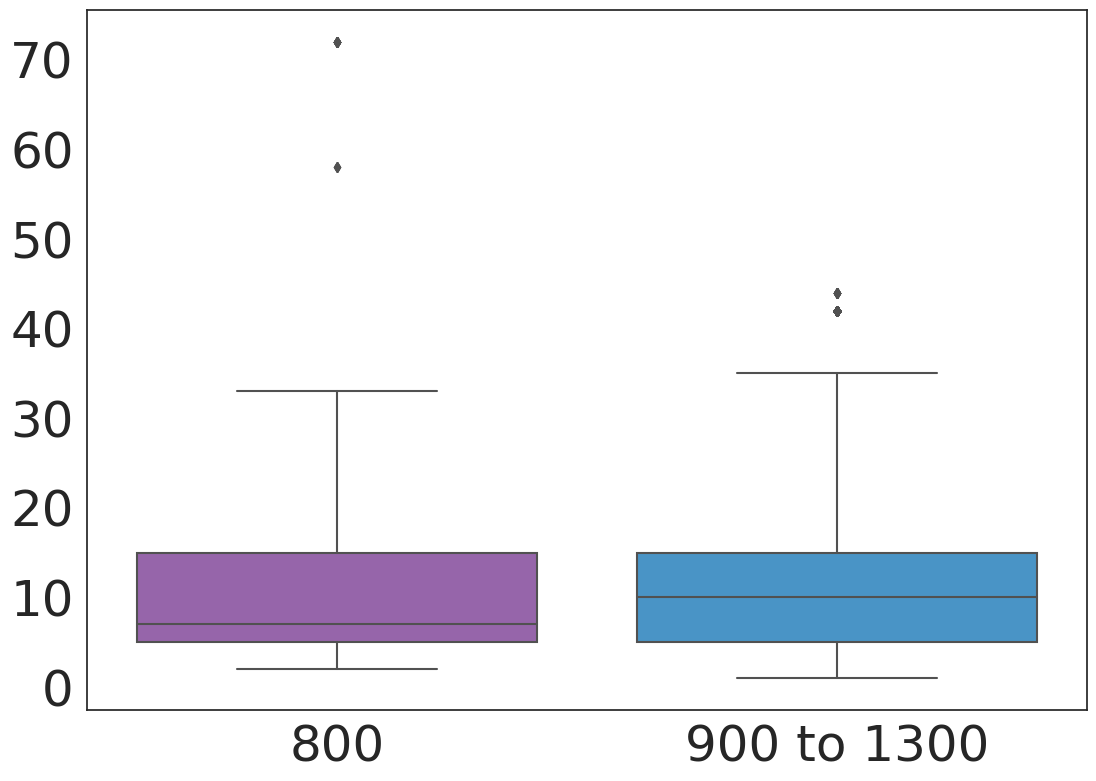

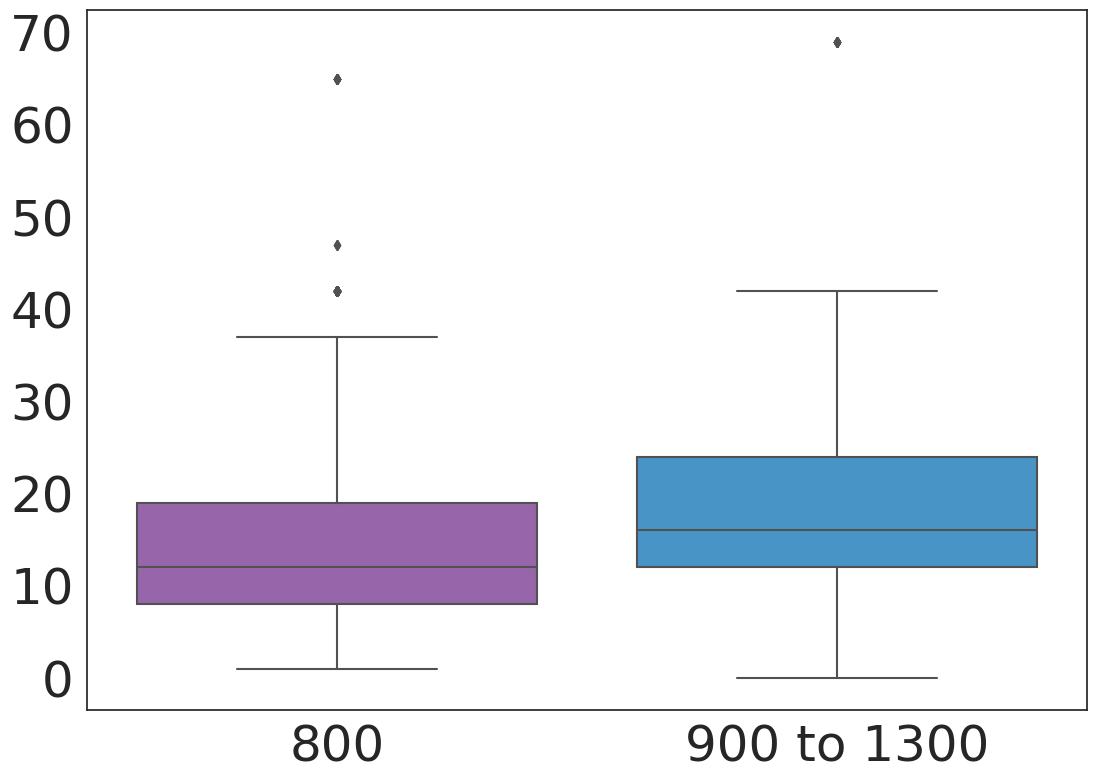

In [82]:
df_after_table7['diff_bin'] = pd.cut(np.array(df_after_table6['Difficulty']), bins=[700,800,1300])
util.plot_box(df_after_table7, figname="fig/locs_by_diff.pdf", 
              xlabel='', ylabel="",
              orient="v",col=['Correct Locs','diff_bin'],
              x_labels=['800', '900 to 1300'],
#               y_labels=[0,10,20,30,40,50,60,70,80],
              figsize=None, whis=2,
              axes=None,font_scale=None,style=None)

util.plot_box(df_after_table7, figname="fig/exprs_by_diff.pdf", 
              xlabel='', ylabel="",
              orient="v",col=['Correct Exprs','diff_bin'],
              x_labels=['800', '900 to 1300'],
#               y_labels=[0,10,20,30,40,50,60,70,80],
              figsize=None, whis=2,
              axes=None,font_scale=None,style=None)

## Figure 18

Technique
CLARA      0.048317
FA(L)      0.456017
FA(L+E)    0.460224
Name: Problem, dtype: float64

/tmp/ipykernel_57168/3096129878.py:91: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size = fontsize)


diff_bin     Technique
(700, 800]   CLARA        0.067903
             FA(L)        0.475319
             FA(L+E)      0.482809
(800, 1300]  CLARA        0.027174
             FA(L)        0.435180
             FA(L+E)      0.435843
Name: Problem, dtype: float64

/tmp/ipykernel_57168/3096129878.py:91: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size = fontsize)


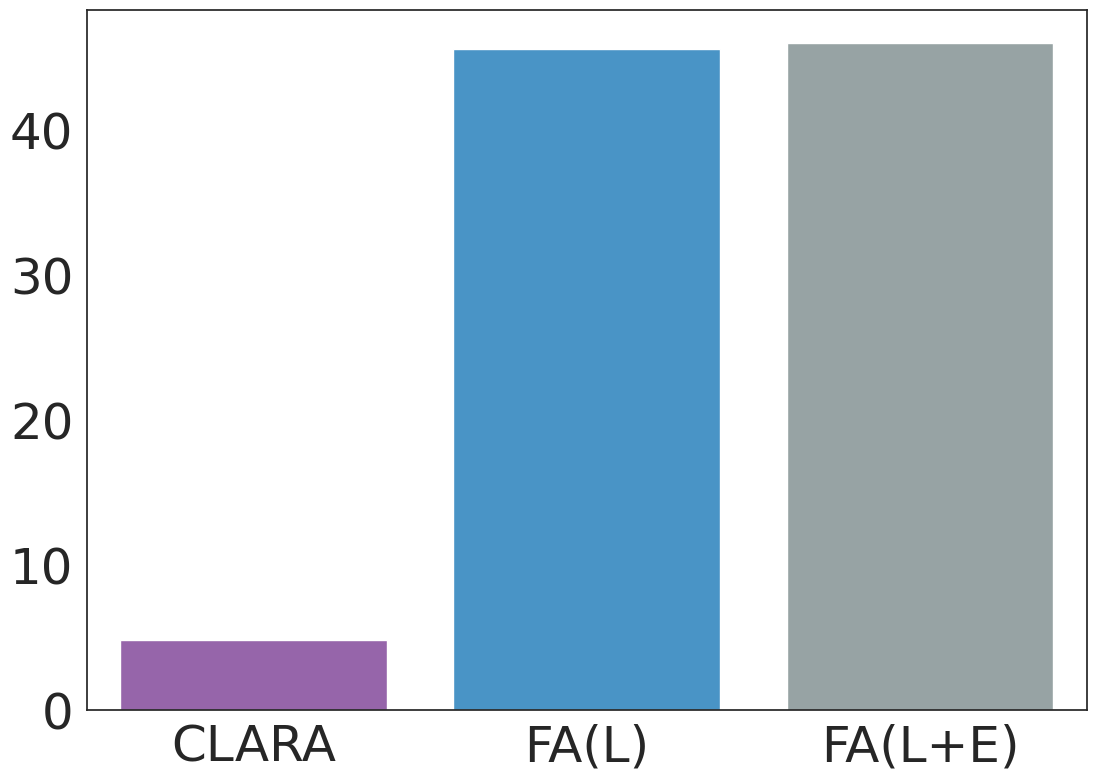

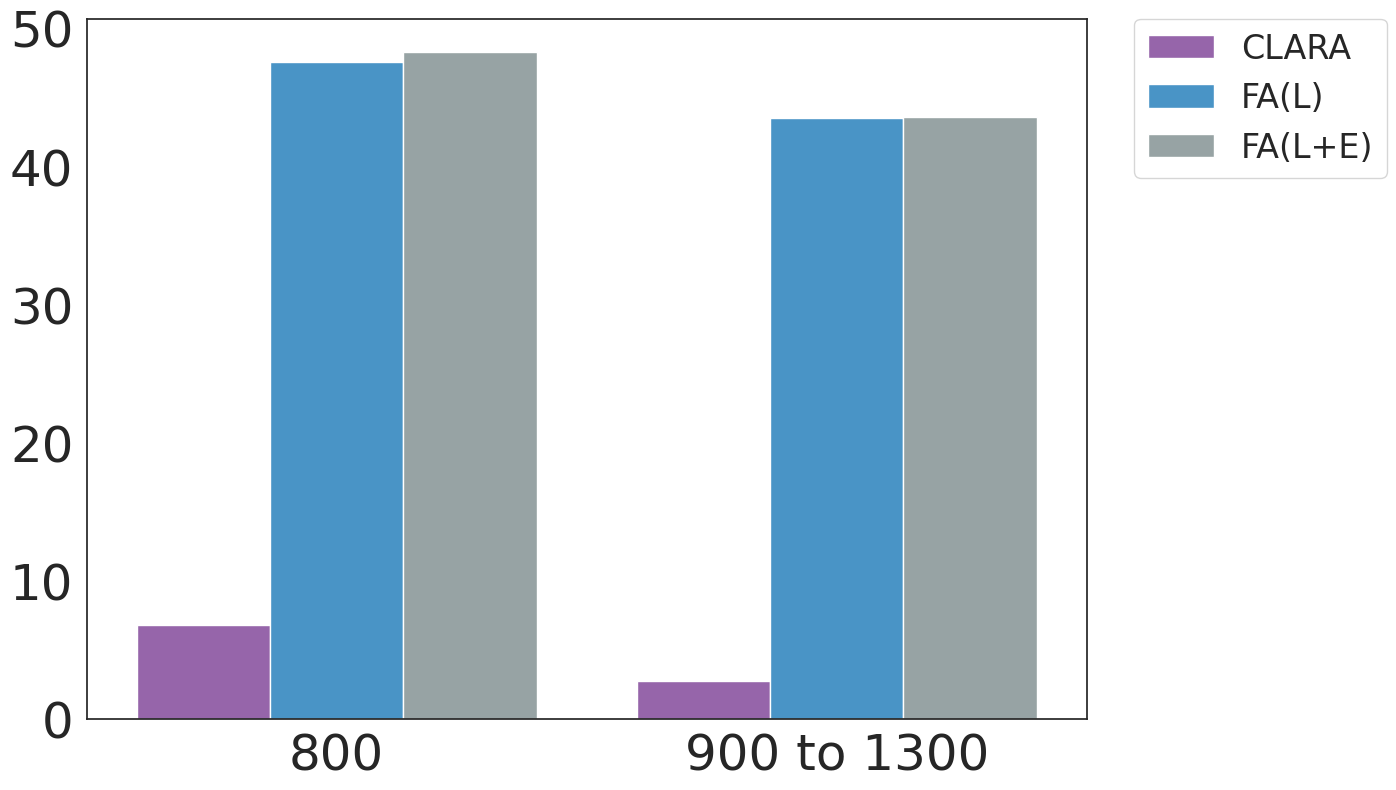

In [96]:
#18a
util.plot_success(df=df_after_table7, figname='fig/successful_repair_by_experiment.pdf',
                  xlabel='', 
                  x_labels=['CLARA', 'FA(L)', 'FA(L+E)'], 
#                   y_labels=[0,10,20,30,40]
                 )
#18b
util.plot_success(df=df_after_table7, 
                  figname='fig/successful_repair_by_diff.pdf',
                  xlabel='', 
                  legend='upper right',
                  x_labels=['800','900 to 1300'],
#                   y_labels=[0,10,20,30,40],
                  col=['diff_bin', 'Technique'])

## Figure 19

locs_bin      Technique
(0.0, 4.0]    CLARA        0.082090
              FA(L)        0.936567
              FA(L+E)      0.937500
(4.0, 5.0]    CLARA        0.137332
              FA(L)        0.924381
              FA(L+E)      0.926988
(5.0, 15.0]   CLARA        0.119128
              FA(L)        0.886885
              FA(L+E)      0.899662
(15.0, 40.0]  CLARA        0.021612
              FA(L)        0.904206
              FA(L+E)      0.917640
(40.0, 80.0]  CLARA             NaN
              FA(L)        0.550239
              FA(L+E)      0.555024
Name: Problem, dtype: float64

/tmp/ipykernel_57168/3096129878.py:91: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size = fontsize)


exprs_bin     Technique
(0.0, 4.0]    CLARA        0.062500
              FA(L)        0.941810
              FA(L+E)      0.937500
(4.0, 10.0]   CLARA        0.170319
              FA(L)        0.882279
              FA(L+E)      0.890420
(10.0, 20.0]  CLARA        0.105650
              FA(L)        0.922013
              FA(L+E)      0.931430
(20.0, 40.0]  CLARA        0.043946
              FA(L)        0.901345
              FA(L+E)      0.910762
(40.0, 80.0]  CLARA             NaN
              FA(L)        0.620301
              FA(L+E)      0.624060
Name: Problem, dtype: float64

/tmp/ipykernel_57168/3096129878.py:91: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size = fontsize)


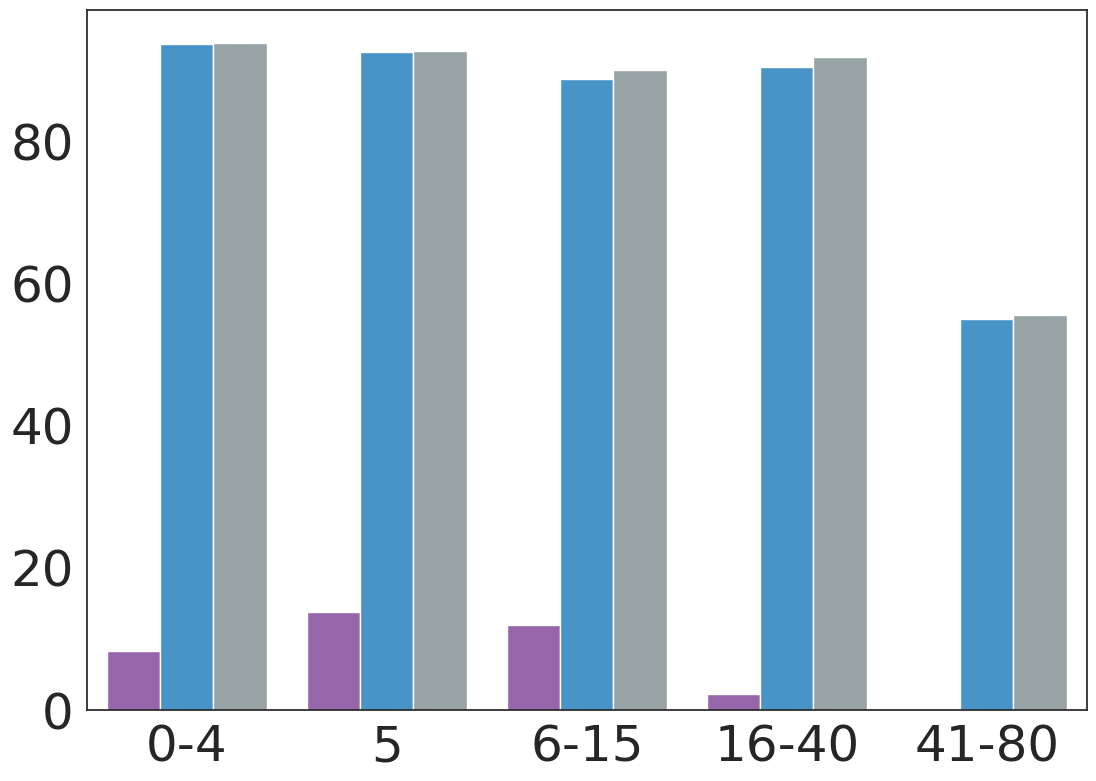

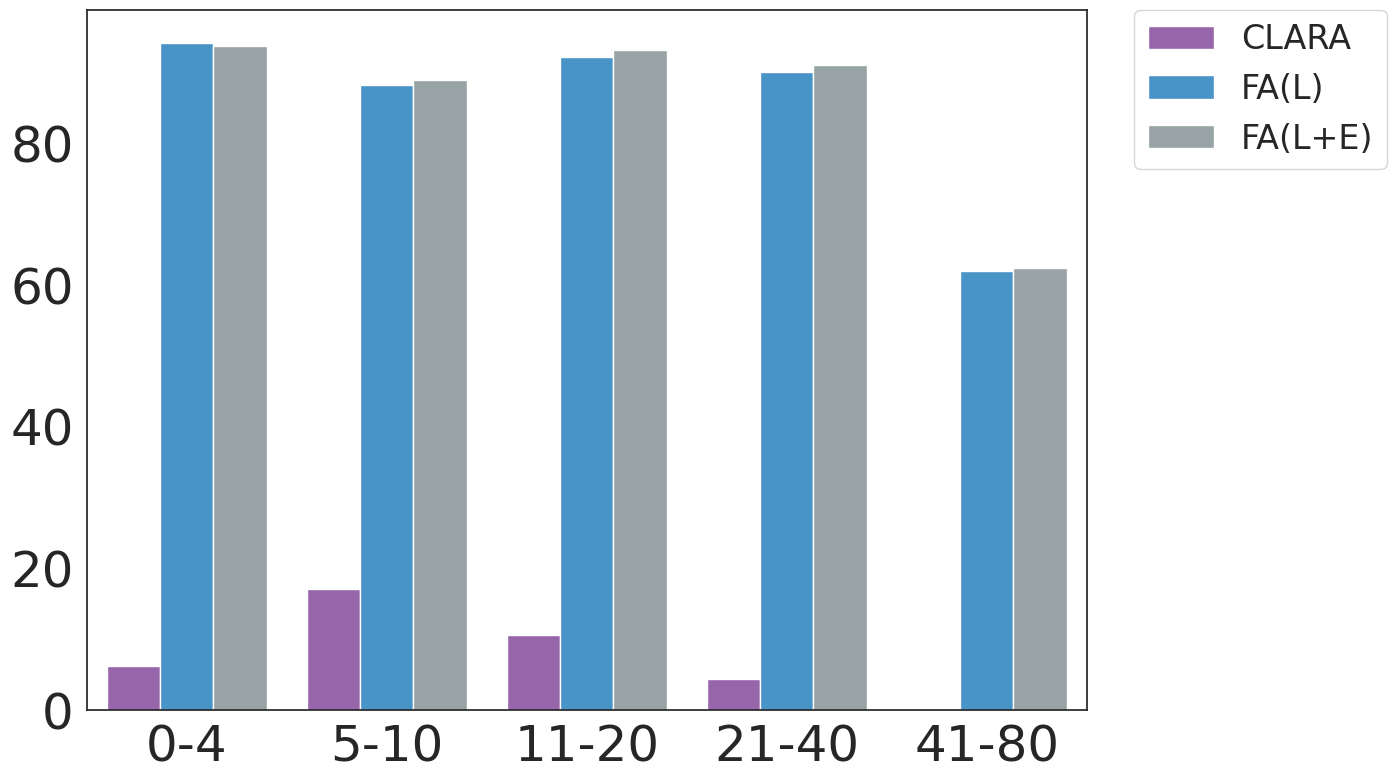

In [97]:
util.plot_success(df=df_after_table7, 
                  figname='fig/successful_repair_by_loc.pdf',
                  xlabel='',
                  x_labels=['0-4','5','6-15','16-40','41-80'],
#                   y_labels=[0,10,20,30,40,50,60,70,80,90,100],
                  col=['locs_bin', 'Technique'])
util.plot_success(df=df_after_table7, 
                  figname='fig/successful_repair_by_exprs.pdf',
                  xlabel='',
                  legend='upper right',
                  x_labels=['0-4','5-10','11-20','21-40','41-80'],
#                   y_labels=[0,20,40,60,80],
                  col=['exprs_bin', 'Technique'])

## Figure 20

/tmp/ipykernel_57168/3096129878.py:136: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size = fontsize)
/tmp/ipykernel_57168/3096129878.py:136: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size = fontsize)


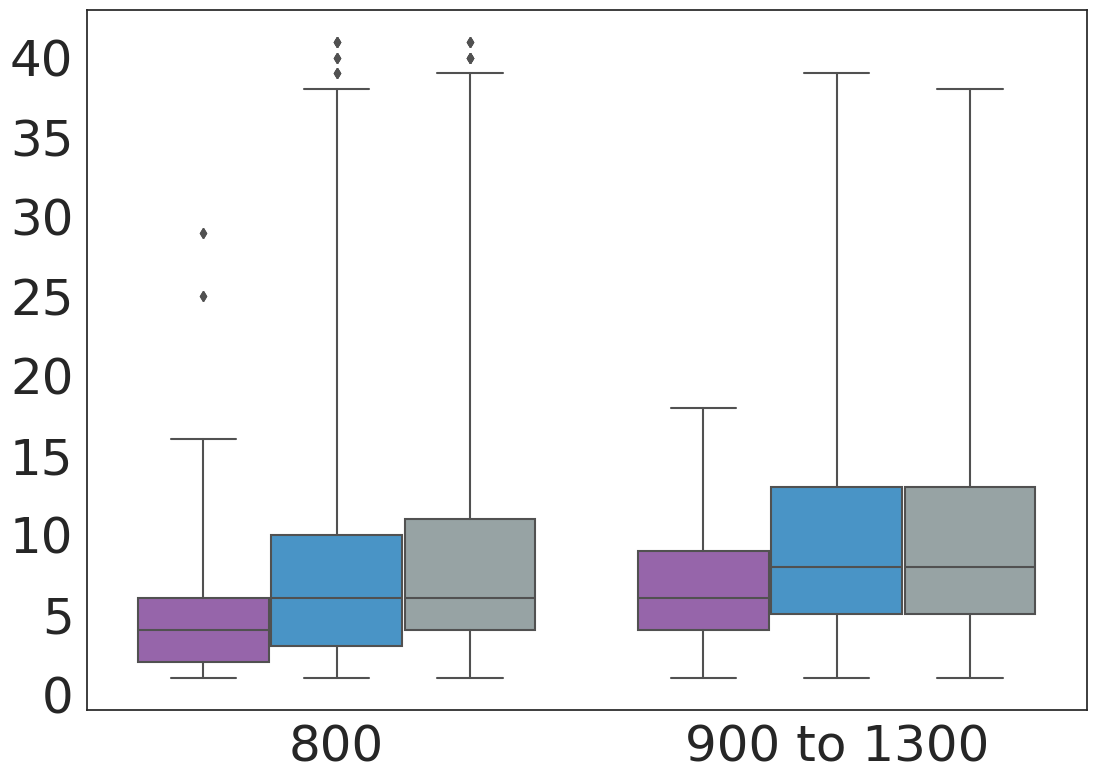

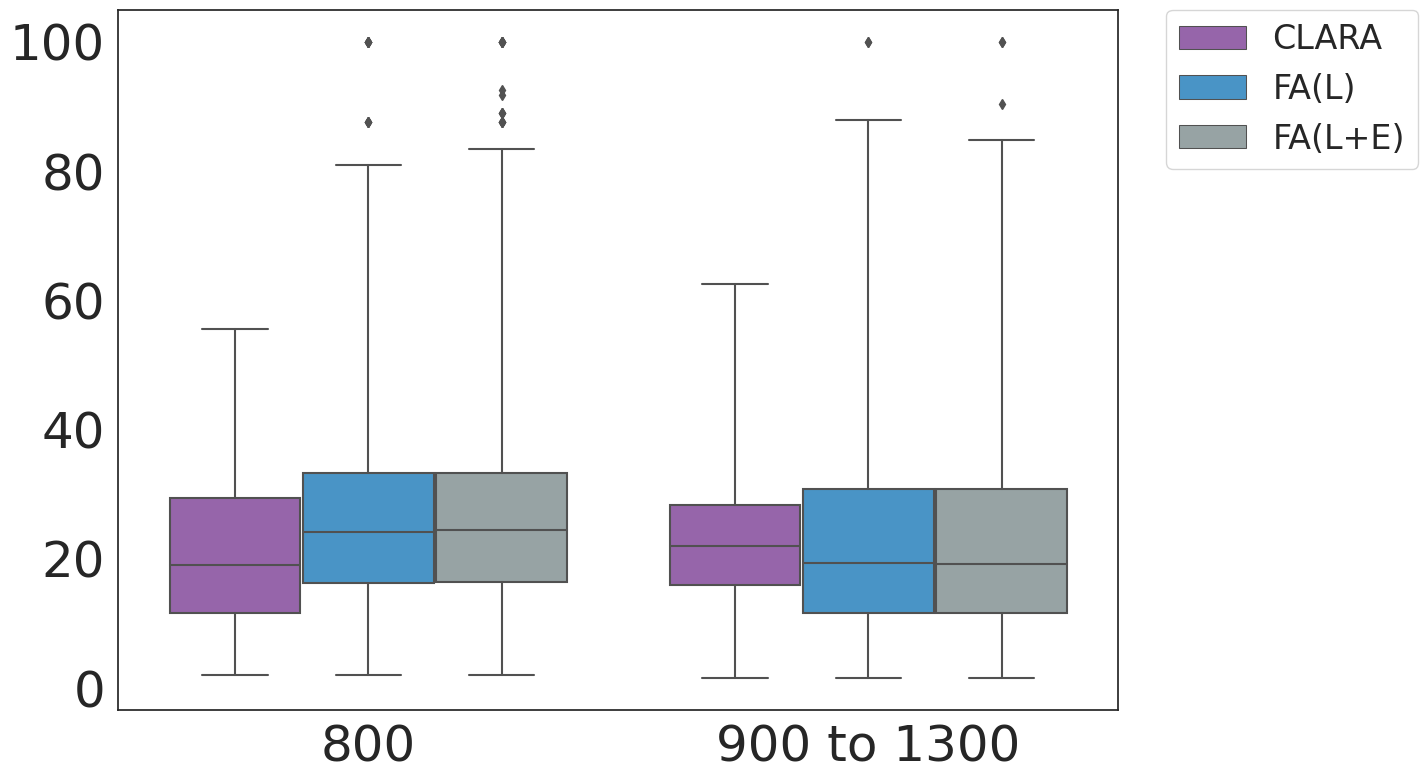

In [98]:
df_fig20 = df_after_table7
df_fig20 = df_fig20[df_fig20['Repairs'].isna() == False]
df_fig20 = df_fig20[df_fig20['Percentage Repaired'].isna() == False]
df_fig20['Repairs'] = df_fig20['Repairs'].astype(int)
df_fig20['Percentage Repaired'] = df_fig20['Percentage Repaired'].astype(float)
# Figure 20a
util.plot_box(df_fig20, figname="fig/repairs_by_diff.pdf", 
              xlabel='', ylabel="",hue='Technique',
              orient="v",col=['Repairs','diff_bin'],
              x_labels=['800', '900 to 1300'],
#               y_labels=[0,0,20,40,60,80,100],
              figsize=None, whis=4,
              axes=None,font_scale=None,style=None)
# Figure 20b
util.plot_box(df_fig20, figname="fig/percentage_repaired_by_diff.pdf", 
              xlabel='', ylabel="",
              hue='Technique',
              orient="v",col=['Percentage Repaired','diff_bin'],
              x_labels=['800', '900 to 1300'],
#               y_labels=[0,0,20,40,60,80,100],
              figsize=None, whis=3, legend='upper right',
              axes=None,font_scale=None,style=None)

## Figure 21

/tmp/ipykernel_57168/3653392991.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fig19['Repairs'] = df_fig19['Repairs'].astype(int)
/tmp/ipykernel_57168/3653392991.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size = 24)
/tmp/ipykernel_57168/3653392991.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fig19['Percentage Repaired'] = df_fig19['Percentage Repaired'].astype(float)
/tmp/ipykernel_57168/3653392991.py:36: Us

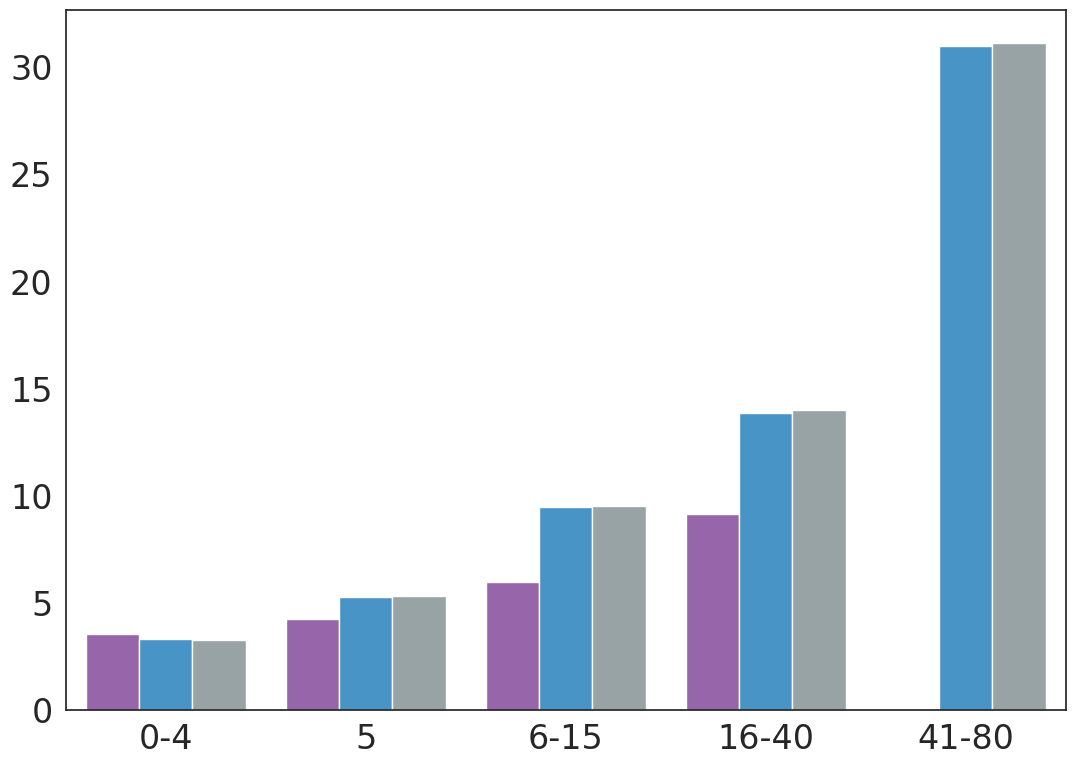

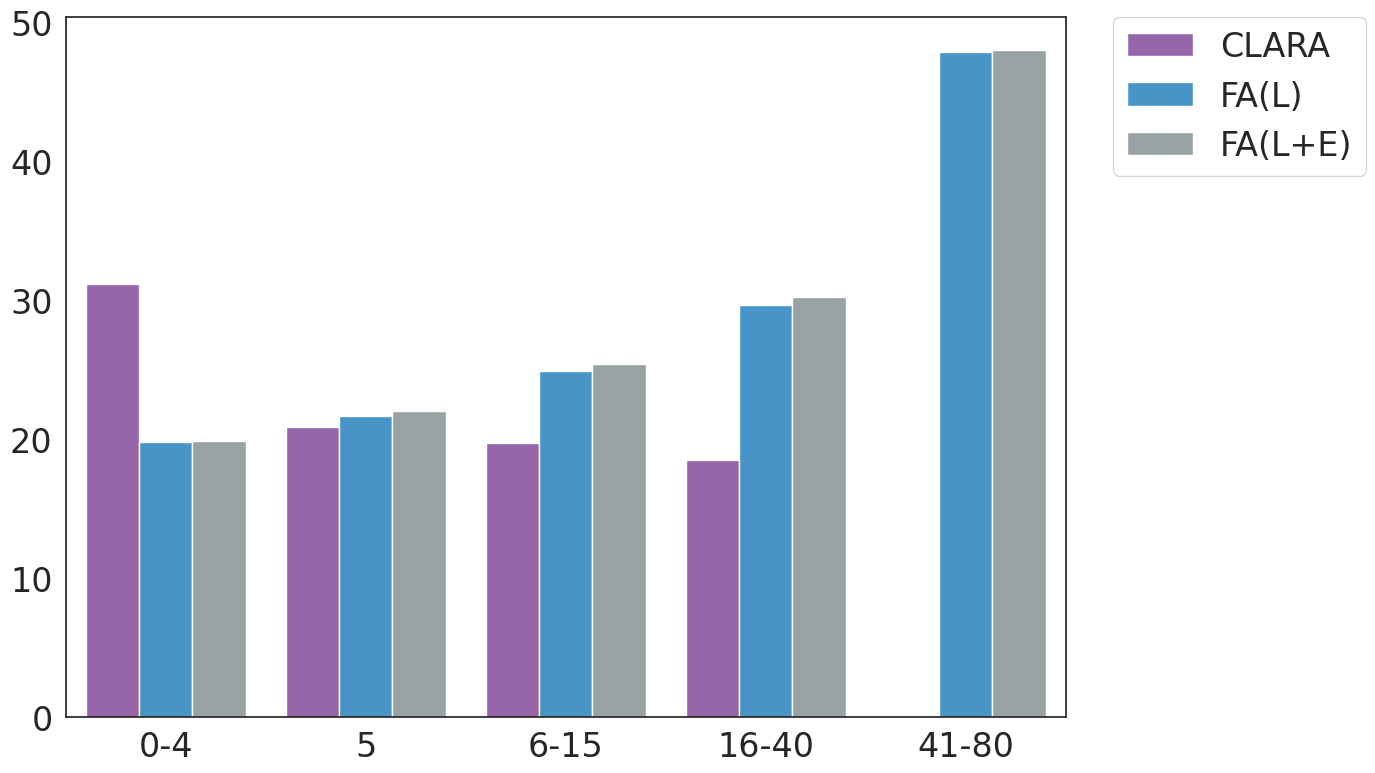

In [102]:
# display(df_after_table7)
# Fig 21a
df_fig19 = df_after_table7
df_fig19 = df_fig19[df_fig19['Repairs'].isna() == False]
df_fig19['Repairs'] = df_fig19['Repairs'].astype(int)
locs = df_fig19.groupby([ 'Technique', 'locs_bin'])['Repairs'].mean()
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
# sns.set(font_scale=1.5)
sns.set_style("white")
sns.barplot(x=locs.index.get_level_values('locs_bin'),
            hue=locs.index.get_level_values('Technique'), 
            y=locs.values, ax=ax, palette=util.palette)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_yticklabels(ax.get_yticklabels(), size = 24)
ax.set_xticklabels(["0-4","5","6-15","16-40","41-80"], size = 24)
ax.legend([], [], frameon=False)
plt.savefig('fig/number_of_repairs_by_loc.pdf', format="pdf", bbox_inches='tight')


# Fig 21b
df_fig19 = df_after_table7
df_fig19 = df_fig19[df_fig19['Repairs'].isna() == False]
df_fig19['Percentage Repaired'] = df_fig19['Percentage Repaired'].astype(float)
exprs = df_fig19.groupby([ 'Technique', 'locs_bin'])['Percentage Repaired'].mean()
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
# sns.set(font_scale=1.5)
sns.set_style("white")
sns.barplot(x=exprs.index.get_level_values('locs_bin'),
            hue=exprs.index.get_level_values('Technique'), 
            y=exprs.values, ax=ax, palette=util.palette)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_yticklabels(ax.get_yticklabels(), size = 24)
ax.set_xticklabels(["0-4","5","6-15","16-40","41-80"], size = 24)
# ax.set_xticklabels(["0-4","5","11-20", "21-40", "41-80"], size = 24)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1), borderaxespad=0, fontsize=24)
plt.savefig('fig/average_percentage_repaired_by_loc.pdf', format="pdf", bbox_inches='tight')

In [104]:
df_after_table7.groupby(['Technique', 'Structure Mismatch'])['Technique'].count()

Technique  Structure Mismatch
CLARA      False                  1235
           True                  14453
FA(L)      False                 15688
FA(L+E)    False                 15688
Name: Technique, dtype: int64

## Figure 22

Problem  Technique
1097A    CLARA        0.013636
         FA(L)        0.227273
         FA(L+E)      0.231818
1360B    CLARA        0.186441
         FA(L)        0.932203
         FA(L+E)      0.932203
1363A    CLARA        0.006674
         FA(L)        0.911012
         FA(L+E)      0.911012
1364A    CLARA        0.011015
         FA(L)        0.211207
         FA(L+E)      0.210967
1369B    CLARA        0.013924
         FA(L)        0.620253
         FA(L+E)      0.624051
1370A    CLARA        0.117530
         FA(L)        0.753984
         FA(L+E)      0.755976
1382B    CLARA        0.167653
         FA(L)        0.792899
         FA(L+E)      0.792899
1385A    CLARA        0.020215
         FA(L)        0.479469
         FA(L+E)      0.480101
1391A    CLARA        0.055463
         FA(L)        0.348057
         FA(L+E)      0.349053
1391B    CLARA        0.050000
         FA(L)        0.780000
         FA(L+E)      0.780000
1A       CLARA        0.132404
         FA(L)      

/tmp/ipykernel_57168/3587223274.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=18)


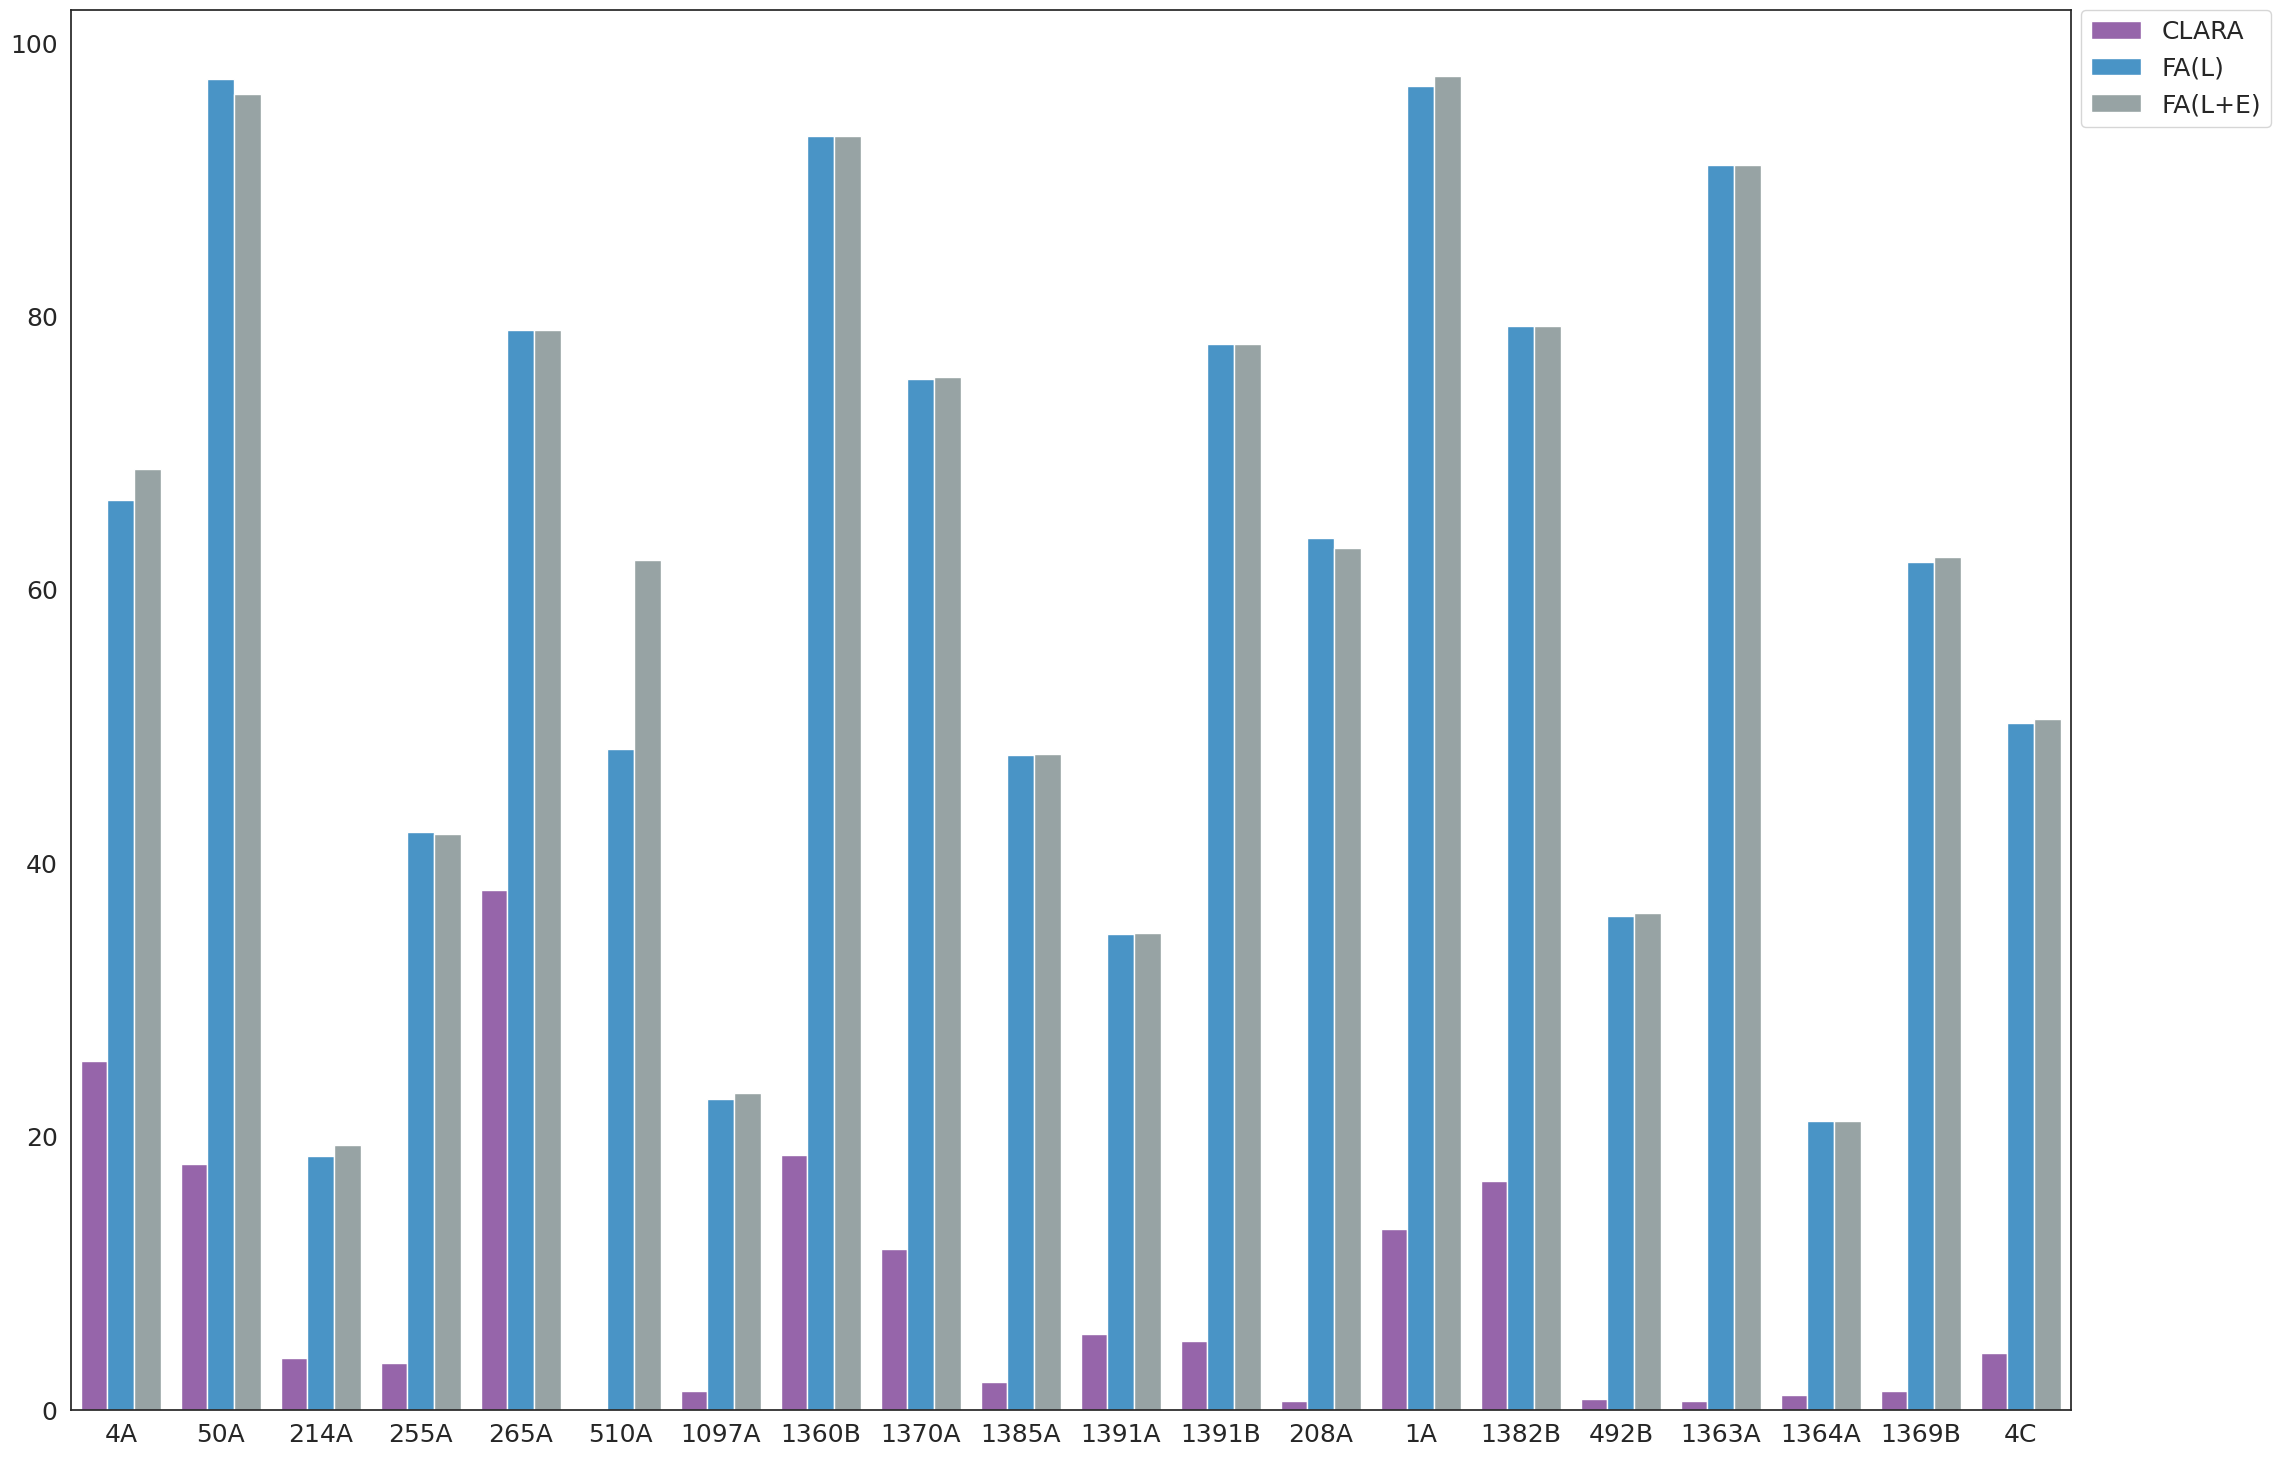

In [12]:
repaired_tech_problem = util.successful_repair_percentage(df_after_table7, col=['Problem', 'Technique'])
print(repaired_tech_problem)
sns.set(font_scale=1)
sns.set_style("white")
fig = plt.figure(figsize =(20, 14))
ax = fig.add_axes([0, 0, 1, 1])
sns.barplot(x=repaired_tech_problem.index.get_level_values('Problem'),
            hue=repaired_tech_problem.index.get_level_values('Technique'), 
            y=repaired_tech_problem.values*100, ax=ax, palette=palette,
            order=util.order)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), size=18)
ax.set_yticklabels(ax.get_yticklabels(), size=18)
ax.legend(loc='upper right',bbox_to_anchor=(1.1, 1), borderaxespad=0, fontsize=18)
plt.savefig('fig/successful_repair_by_problem.pdf', format="pdf", bbox_inches='tight')

In [13]:
## Fig 22 addendum
repaired_tech_problem = util.successful_repair_percentage(df_after_table7, col=['Problem', 'Technique'])
tmp = df_after_table7[df_after_table7['Problem'] == '510A'][['Technique', 'Correct Locs', 'ci']]
tmp

,Technique,Correct Locs,ci
30436,CLARA,NaN,122288372_86894470
30437,FA(L),15.0,122288372_86894470
30438,FA(L+E),15.0,122288372_86894470
30442,CLARA,NaN,18717839_86894470
30443,FA(L),NaN,18717839_86894470
...,...,...,...
32752,FA(L),NaN,86147096_105048445
32753,FA(L+E),15.0,86147096_105048445
32754,CLARA,NaN,161871442_105048445
32755,FA(L),NaN,161871442_105048445


## Figure 23

/tmp/ipykernel_57168/4103093992.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fig19['Percentage Repaired'] = df_fig19['Percentage Repaired'].astype(float)
/tmp/ipykernel_57168/4103093992.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size = 18)


Problem  Technique
1097A    CLARA        18.230723
         FA(L)        31.872220
         FA(L+E)      32.216801
1360B    CLARA        24.341321
         FA(L)        30.363051
         FA(L+E)      29.675814
1363A    CLARA        24.503970
         FA(L)        25.835961
         FA(L+E)      25.815220
1364A    CLARA        15.069085
         FA(L)        20.589019
         FA(L+E)      20.400603
1369B    CLARA        15.485641
         FA(L)        23.210684
         FA(L+E)      23.518444
1370A    CLARA        16.550120
         FA(L)        20.202915
         FA(L+E)      20.418254
1382B    CLARA        22.400488
         FA(L)        24.925171
         FA(L+E)      24.880129
1385A    CLARA        17.770204
         FA(L)        29.879654
         FA(L+E)      29.916947
1391A    CLARA        25.986684
         FA(L)        27.733551
         FA(L+E)      28.292135
1391B    CLARA        14.556501
         FA(L)        23.839003
         FA(L+E)      23.638749
1A       CLARA       

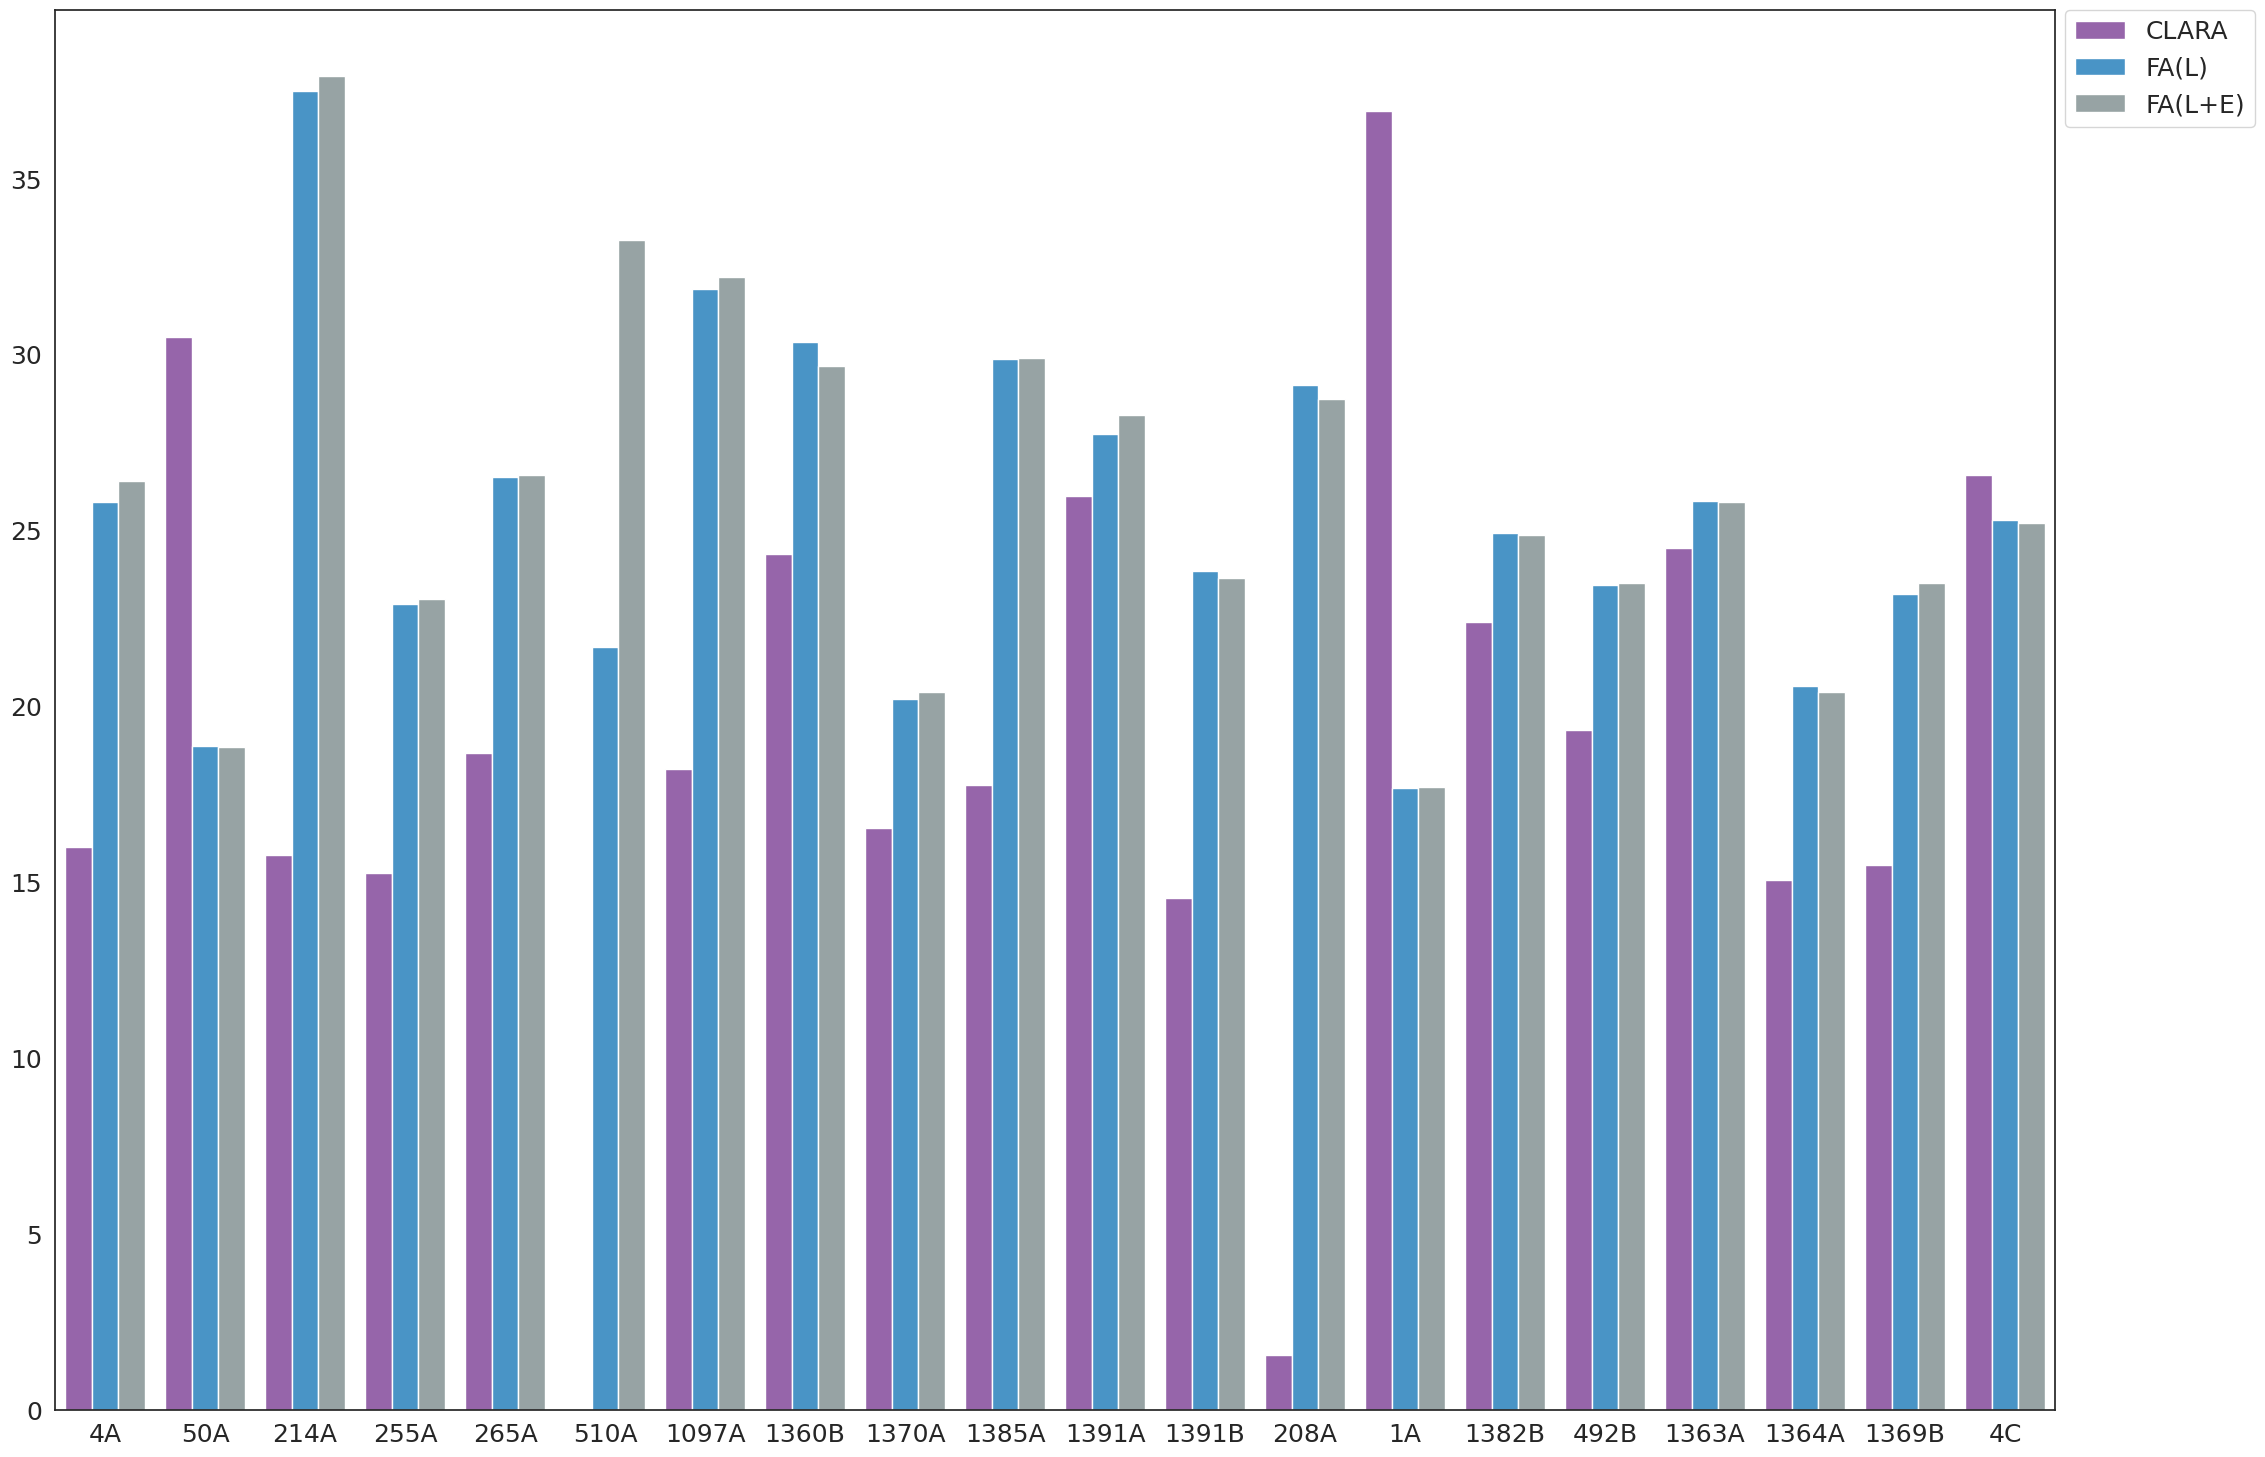

In [14]:
df_fig19 = df_after_table7
df_fig19 = df_fig19[df_fig19['Percentage Repaired'].isna() == False]
df_fig19['Percentage Repaired'] = df_fig19['Percentage Repaired'].astype(float)
locs = df_fig19.groupby([ 'Problem', 'Technique'])['Percentage Repaired'].mean()
print(locs)
fig = plt.figure(figsize =(20, 14))
ax = fig.add_axes([0, 0, 1, 1])
# sns.set(font_scale=1.5)
sns.set_style("white")
sns.barplot(x=locs.index.get_level_values('Problem'),
            hue=locs.index.get_level_values('Technique'), 
            y=locs.values, ax=ax, palette=util.palette,
           order=util.order)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_yticklabels(ax.get_yticklabels(), size = 18)
ax.set_xticklabels(ax.get_xticklabels(), size = 18)
# ax.legend([], [], frameon=False)
ax.legend(loc='upper right',bbox_to_anchor=(1.1, 1), borderaxespad=0, fontsize=18)
plt.savefig('fig/percentage_repaired_by_problem.pdf', format="pdf", bbox_inches='tight')

In [15]:
loc_bin.groupby(['Technique', 'locs_bin'])['locs_bin'].count()

NameError: name 'loc_bin' is not defined

In [ ]:
util.plot_success(df=loc_bin, 
                  figname='successful_repair_by_loc.pdf',
                  xlabel='',
                  x_labels=['0-4','5','6-15','15-40','40-80'],
                  y_labels=[0,20,40,60,80],
                  col=['locs_bin', 'Technique'])

In [ ]:
locs = loc_bin.groupby(['locs_bin', 'Technique'])['Percentage Repaired'].mean()
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
# sns.set(font_scale=1.5)
sns.set_style("white")
sns.barplot(x=locs.index.get_level_values('locs_bin'),
            hue=locs.index.get_level_values('Technique'), 
            y=locs.values, ax=ax, palette=util.palette)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_yticklabels([0,10,20,30,40,50], size = 24)
ax.set_xticklabels(["0-4","5","6-15","16-40","40-80"], size = 24)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1), borderaxespad=0, fontsize=24)
# ax.legend([],[],frameon=False)
plt.savefig('average_percentage_repaired_by_loc.pdf', format="pdf", bbox_inches='tight')

In [ ]:
locs = loc_bin.groupby(['locs_bin', 'Technique'])['Repairs'].mean()
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
# sns.set(font_scale=1.5)
# sns.set_style("white")
sns.barplot(x=locs.index.get_level_values('locs_bin'),
            hue=locs.index.get_level_values('Technique'), 
            y=locs.values, ax=ax, palette=util.palette)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_yticklabels([0,5,10,15,20,25,30], size = 24)
ax.set_xticklabels(["0-4","5","6-15","16-40","40-80"], size = 24)
# ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1), borderaxespad=0, fontsize=24)
ax.legend([],[],frameon=False)
plt.savefig('number_of_repairs_by_loc.pdf', format="pdf", bbox_inches='tight')

In [ ]:
exprs_bin = util.do_bin(df=clara.dataframe, 
            new_col='exprs_bin', 
            bin_column='Correct Exprs', 
            bins=[0,10,20,70])
exprs_bin.groupby('exprs_bin')['exprs_bin'].count()

In [ ]:
util.plot_success(df=exprs_bin, 
                  figname='successful_repair_by_exprs.pdf',
                  xlabel='', 
                  legend='upper right',
                  x_labels=['0-10','10-20','20-70'],
                  y_labels=[0,20,40,60,80],
                  col=['exprs_bin', 'Technique'])

In [ ]:
exprs = exprs_bin.groupby(['exprs_bin', 'Technique'])['Percentage Repaired'].mean()
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
# sns.set(font_scale=1.5)
sns.set_style("white")
sns.barplot(x=exprs.index.get_level_values('exprs_bin'),
            hue=exprs.index.get_level_values('Technique'), 
            y=exprs.values, ax=ax, palette=util.palette)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_yticklabels([0,5,10,15,20,25,30], size = 24)
ax.set_xticklabels(["0-10","11-20","21-70"], size = 24)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1), borderaxespad=0, fontsize=24)
plt.savefig('average_percentage_repaired_by_exprs.pdf', format="pdf", bbox_inches='tight')

In [ ]:
exprs = exprs_bin.groupby(['exprs_bin', 'Technique'])['Repairs'].mean()
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
# sns.set(font_scale=1.5)
sns.set_style("white")
sns.barplot(x=exprs.index.get_level_values('exprs_bin'),
            hue=exprs.index.get_level_values('Technique'), 
            y=exprs.values, ax=ax, palette=util.palette)
ax.set_ylabel("")
ax.set_xlabel("")
# ax.set_yticklabels([0,5,10,15,20,25,30], size = 24)
# ax.set_xticklabels(["0-10","11-20","21-70"], size = 24)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1), borderaxespad=0, fontsize=24)
plt.savefig('number_of_repairs_by_exprs.pdf', format="pdf", bbox_inches='tight')

In [ ]:
diff_bin = util.do_bin(df=clara.dataframe, 
            new_col='diff_bin', 
            bin_column='Difficulty', 
            bins=[700,800,1300])

In [ ]:
diff_bin.groupby('diff_bin')['diff_bin'].count()

In [ ]:
util.plot_success(df=diff_bin, 
                  figname='successful_repair_by_diff.pdf',
                  xlabel='', 
                  legend='upper right',
                  x_labels=['800','900 to 1300'],
                  y_labels=[0,10,20,30,40],
                  col=['diff_bin', 'Technique'])

In [ ]:
util.plot_box(diff_bin, figname="percentage_repaired_by_diff.pdf", 
              xlabel='', ylabel="",hue='Technique',
              orient="v",col=['Percentage Repaired','diff_bin'],
              x_labels=['800', '900 to 1300'],
              y_labels=[0,0,20,40,60,80,100],
              figsize=None, whis=3, legend='upper right',
              axes=None,font_scale=None,style=None)

In [ ]:
diff_bin.groupby(['diff_bin', 'Technique'])['Percentage Repaired'].mean()

In [ ]:
util.plot_box(diff_bin, figname="repairs_by_diff.pdf", 
              xlabel='', ylabel="",hue='Technique',
              orient="v",col=['Repairs','diff_bin'],
              x_labels=['800', '900 to 1300'],
              y_labels=[0,0,5,10,15,20,25,30,35,40],
              figsize=None, whis=4,
              axes=None,font_scale=None,style=None)

In [ ]:
util.plot_box(diff_bin, figname="locs_by_diff.pdf", 
              xlabel='', ylabel="",
              orient="v",col=['Correct Locs','diff_bin'],
              x_labels=['800', '900 to 1300'],
              y_labels=[0,10,20,30,40,50,60,70,80],
              figsize=None, whis=1.5,
              axes=None,font_scale=None,style=None)

In [ ]:
util.plot_box(diff_bin, figname="exprs_by_diff.pdf", 
              xlabel='', ylabel="",
              orient="v",col=['Correct Exprs','diff_bin'],
              x_labels=['800', '900 to 1300'],
              y_labels=[0,10,20,30,40,50,60,70,80],
              figsize=None, whis=1.5,
              axes=None,font_scale=None,style=None)